In [1]:
# Supressing all the warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
import findspark
findspark.init('Path_to_Spark_Installation_Folder')

# Initializing the Spark Session
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

# Reading the data
data = spark.read.csv('Customers.csv', header = True, inferSchema = True)

In [5]:
data.printSchema()

root
 |-- CustomerID: integer (nullable = true)
 |-- Genre: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Annual Income (k$): integer (nullable = true)
 |-- Spending Score (1-100): integer (nullable = true)



In [6]:
data.show(10)

+----------+------+---+------------------+----------------------+
|CustomerID| Genre|Age|Annual Income (k$)|Spending Score (1-100)|
+----------+------+---+------------------+----------------------+
|         1|  Male| 19|                15|                    39|
|         2|  Male| 21|                15|                    81|
|         3|Female| 20|                16|                     6|
|         4|Female| 23|                16|                    77|
|         5|Female| 31|                17|                    40|
|         6|Female| 22|                17|                    76|
|         7|Female| 35|                18|                     6|
|         8|Female| 23|                18|                    94|
|         9|  Male| 64|                19|                     3|
|        10|Female| 30|                19|                    72|
+----------+------+---+------------------+----------------------+
only showing top 10 rows



In [7]:
# Considering only two columns(Annual Income (k$) and Spending Score (1-100)) so that we can visualize our data in 2D
# In real world pronem we want to as many significant features as available
from pyspark.sql.functions import *
data = data.select(col('Annual Income (k$)').alias('Income'), col('Spending Score (1-100)').alias('Score'))
data.show(10)

+------+-----+
|Income|Score|
+------+-----+
|    15|   39|
|    15|   81|
|    16|    6|
|    16|   77|
|    17|   40|
|    17|   76|
|    18|    6|
|    18|   94|
|    19|    3|
|    19|   72|
+------+-----+
only showing top 10 rows



In [8]:
data.columns

['Income', 'Score']

*** Since a machine learning model in Spark needs the data to be in 'feature' & 'label' format, we need to convert all the features into a single column - vector of all feature. And, this is a unsupervised model we will need only 'feature' ***

In [2]:
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols = data.columns, outputCol = 'features')
final_data = assembler.transform(data)
final_data.show(5)

ImportError: No module named 'pyspark'

*** Clustering is an unsupervised model, so we need to define how amny clusters we want in our model. But at this stage, we do not know what is the best number of clusters to define. So, we will uses a technique called 'Elbow Method' to determine the best number of clusters. In this methid we calculate the clustering performance metric - within set sum of squared error - for a range of values of cluster. Then we check the number of clusters at which the error somehow starts to converge. In simple words, the point where the error stops to deop significantly. ***

In [25]:
from pyspark.ml.clustering import KMeans

wcss = []
for i in range(2, 11):
    kmeans = KMeans(k = i, initMode = 'k-means||', maxIter = 100, initSteps = 10)
    # choose initMode = 'k-means||' to avoid random initialization trap
    # initMode = 'k-means||' uses k-means++ algorithm
    # maxIter = number of iteration the algorithm goes through to find optimal value of centroids
    # initSteps = number of times the K-means algorithm runs
    model = kmeans.fit(final_data)
    # Evaluating clustering by computing Within Set Sum of Squared Errors
    wssse = model.computeCost(final_data)
    wcss.append(wssse)   

In [3]:
# Visualizing the Elbow
import matplotlib.pyplot as plt

plt.plot(range(2, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

NameError: name 'wcss' is not defined

*** Here, it is very clear that the abrupt drop in error stops at number_of_cluster = 5. Hence, baesd on the eblow method concept, the best number of clusters to consider would be 5. ***

In [27]:
# Training k-means model with k=5
kmeans = KMeans(k = 5, initMode = 'k-means||', maxIter = 300, initSteps = 10)
model = kmeans.fit(final_data)

# Centers of theeach cluster
centers = model.clusterCenters()
print('Cluster Centers -------------')
for center in centers:
    print(center)

Within Set Sum of Squared Errors = 44454.48
Cluster Centers -------------
[ 86.53846154  82.12820513]
[ 25.72727273  79.36363636]
[ 87.75        17.58333333]
[ 26.30434783  20.91304348]
[ 55.0875  49.7125]


*** As discussed earlier, our orifinal data does have label for the cluster to determine which data point falls into which cluster. So let's calculate the cluster for each data point bae=sed on our model. ***

In [28]:
output = model.transform(final_data)
output.show(5)

In [40]:
# Convertind Spark dataframe to Pandas dataframe for visualization purpose
df = output.toPandas()
df.head()

array([3, 1, 4, 0, 2], dtype=int64)

In [30]:
df.prediction.unique()

,Income,Score,features,prediction
0,15,39,"[15.0, 39.0]",3
1,15,81,"[15.0, 81.0]",1
2,16,6,"[16.0, 6.0]",3
3,16,77,"[16.0, 77.0]",1
4,17,40,"[17.0, 40.0]",3


In [ ]:
import pandas as pd
cluster_center = pd.DataFrame(centers)

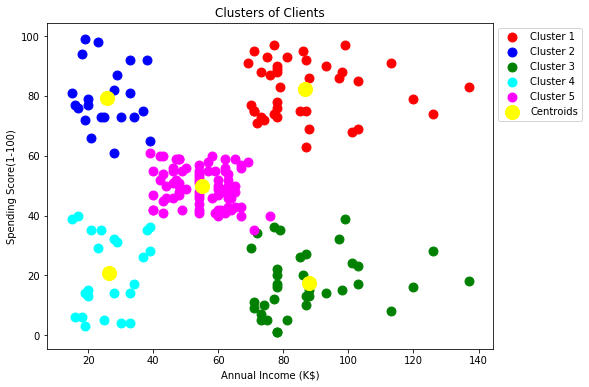

In [68]:
# Visualizing the clusters
plt.figure(figsize = (8, 6))
plt.scatter(df[df.prediction == 0]['Income'], df[df.prediction == 0]['Score'], s = 80, c = 'red', label = 'Cluster 1')
plt.scatter(df[df.prediction == 1]['Income'], df[df.prediction == 1]['Score'], s = 80, c = 'blue', label = 'Cluster 2')
plt.scatter(df[df.prediction == 2]['Income'], df[df.prediction == 2]['Score'], s = 80, c = 'green', label = 'Cluster 3')
plt.scatter(df[df.prediction == 3]['Income'], df[df.prediction == 3]['Score'], s = 80, c = 'cyan', label = 'Cluster 4')
plt.scatter(df[df.prediction == 4]['Income'], df[df.prediction == 4]['Score'], s = 80, c = 'magenta', label = 'Cluster 5')

# lets plot the centroids:
plt.scatter(cluster_center.iloc[:, 0], cluster_center.iloc[:, 1], s = 200, c = 'yellow', label = 'Centroids')

plt.title('Clusters of Clients')
plt.xlabel('Annual Income (K$)')
plt.ylabel('Spending Score(1-100)')
plt.legend(loc = 2, bbox_to_anchor=(1,1))
plt.show()